In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
tumor_dir = os.getcwd() + "\data" + "\BrainTumor"
healthy_dir = os.getcwd() + "\data" + "\Healthy"

In [4]:
tumors = os.listdir(tumor_dir)
healthy = os.listdir(healthy_dir)

In [5]:
min = 1e9
for i in pd.read_csv("metadata_rgb_only.csv")["shape"]:
    i = tuple(map(int, i[1:-1].split(', ')))
    if int(i[0]) < min:
        if int(i[1]) < int(i[0]):
            min = int(i[1])
        min = int(i[0])
print(min)

167


In [6]:
metadata = pd.read_csv("metadata_rgb_only.csv")

X_rgb = []
X_gray = []
y = []

for file in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    if file[1]["class"] == "tumor":
        img = Image.open(tumor_dir + "\\" + file[1]["image"]).resize((167, 167))
        img_arr_rgb = np.array(img)
        img_arr_gray = np.dot(img_arr_rgb[...,:3], [0.2989, 0.5870, 0.1140])

        img_arr_rgb = list(img_arr_rgb.flatten())
        img_arr_gray = list(img_arr_gray.flatten())

        X_rgb.append(img_arr_rgb)
        X_gray.append(img_arr_gray)
        y.append("tumor")
    elif file[1]["class"] == "normal":
        img = Image.open(healthy_dir + "\\" + file[1]["image"]).resize((167, 167))
        img_arr_rgb = np.array(img)
        img_arr_gray = np.dot(img_arr_rgb[...,:3], [0.2989, 0.5870, 0.1140])

        img_arr_rgb = list(img_arr_rgb.flatten())
        img_arr_gray = list(img_arr_gray.flatten())

        X_rgb.append(img_arr_rgb)
        X_gray.append(img_arr_gray)
        y.append("normal")

100%|██████████| 4461/4461 [01:18<00:00, 56.56it/s] 


In [7]:
Xg_train, Xg_test, y_train, y_test = train_test_split(X_gray, y, test_size=0.2, random_state=42)

mdl = LogisticRegression(C=1, max_iter=10000)

mdl.fit(Xg_train, y_train)

LogisticRegression(C=1, max_iter=10000)

In [8]:
print(classification_report(y_test, mdl.predict(Xg_test)))

              precision    recall  f1-score   support

      normal       0.95      0.97      0.96       388
       tumor       0.97      0.96      0.97       505

    accuracy                           0.97       893
   macro avg       0.96      0.97      0.96       893
weighted avg       0.97      0.97      0.97       893



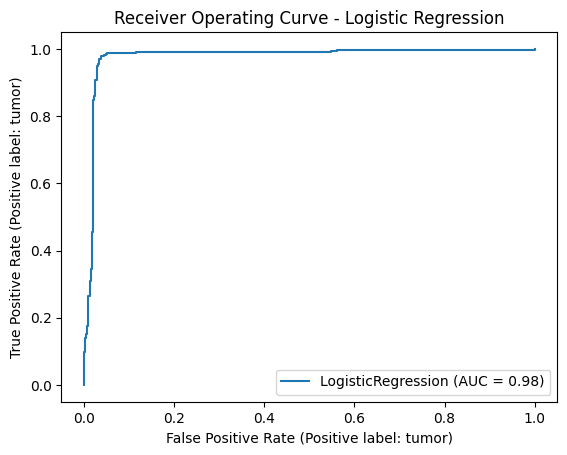

In [11]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(mdl, Xg_test, y_test)
plt.title("Receiver Operating Curve - Logistic Regression")
plt.savefig("LR_ROC.png")

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
import keras
import tensorflow as tf

In [21]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/",
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
  color_mode="grayscale")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/",
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical",
  color_mode="grayscale")

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Found 4514 files belonging to 2 classes.
Using 902 files for validation.


In [22]:
# Define the MLP model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(180, 180, 1)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
113/113 [==============================] - 5s 39ms/step - loss: 88.1033 - accuracy: 0.6570 - precision: 0.6314 - recall: 0.6287 - val_loss: 14.1448 - val_accuracy: 0.7949 - val_precision: 0.7855 - val_recall: 0.7916
Epoch 2/10
113/113 [==============================] - 4s 38ms/step - loss: 22.8884 - accuracy: 0.7807 - precision: 0.7442 - recall: 0.7428 - val_loss: 19.4278 - val_accuracy: 0.7761 - val_precision: 0.8194 - val_recall: 0.7295
Epoch 3/10
113/113 [==============================] - 4s 38ms/step - loss: 15.1058 - accuracy: 0.8267 - precision: 0.7952 - recall: 0.7998 - val_loss: 6.9603 - val_accuracy: 0.8548 - val_precision: 0.8268 - val_recall: 0.8836
Epoch 4/10
113/113 [==============================] - 4s 37ms/step - loss: 7.9207 - accuracy: 0.8605 - precision: 0.8454 - recall: 0.8416 - val_loss: 6.4651 - val_accuracy: 0.8437 - val_precision: 0.8653 - val_recall: 0.7694
Epoch 5/10
113/113 [==============================] - 4s 38ms/step - loss: 3.8561 - accuracy: 0

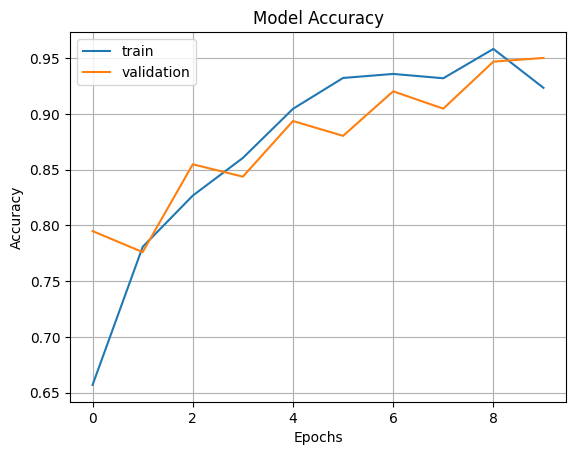

In [23]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("MLP_accuracy.png")

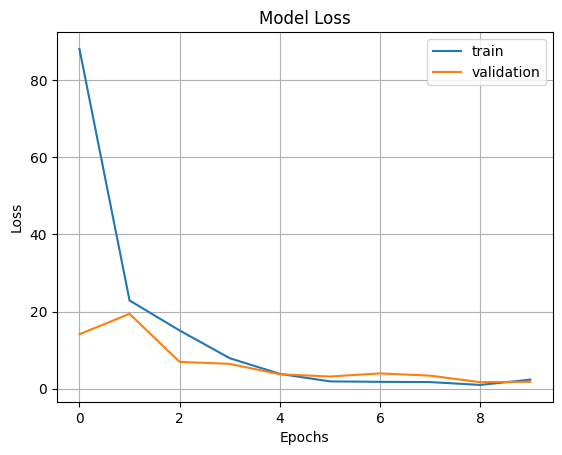

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('MLP_loss.png')

In [25]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(180, 180, 1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(2, activation='softmax'))

# compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], optimizer='adam')

# training the model for 10 epochs
history = model.fit(train_ds, batch_size=128, epochs=10, validation_data=val_ds)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)

Epoch 1/10
113/113 [==============================] - 89s 780ms/step - loss: 186.9144 - accuracy: 0.7528 - precision: 0.7528 - recall: 0.7528 - val_loss: 26.8858 - val_accuracy: 0.8293 - val_precision: 0.8293 - val_recall: 0.8293
Epoch 2/10
113/113 [==============================] - 87s 772ms/step - loss: 7.1427 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - val_loss: 5.2745 - val_accuracy: 0.9424 - val_precision: 0.9424 - val_recall: 0.9424
Epoch 3/10
113/113 [==============================] - 87s 774ms/step - loss: 1.8824 - accuracy: 0.9687 - precision: 0.9687 - recall: 0.9687 - val_loss: 4.2366 - val_accuracy: 0.9656 - val_precision: 0.9656 - val_recall: 0.9656
Epoch 4/10
113/113 [==============================] - 87s 773ms/step - loss: 2.3630 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - val_loss: 4.0228 - val_accuracy: 0.9490 - val_precision: 0.9490 - val_recall: 0.9490
Epoch 5/10
113/113 [==============================] - 87s 774ms/step - loss: 0.7470 - acc

ValueError: too many values to unpack (expected 2)

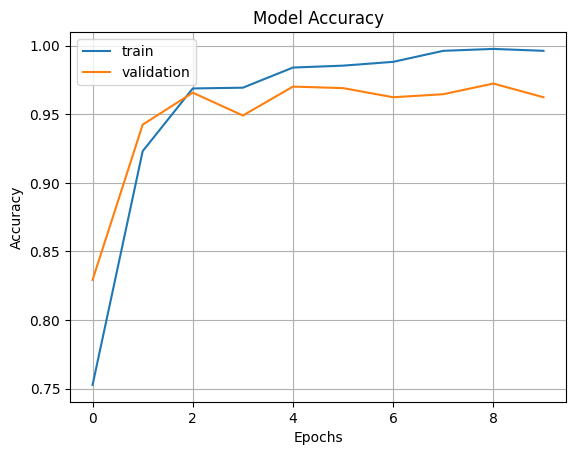

In [26]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("CNN_accuracy.png")

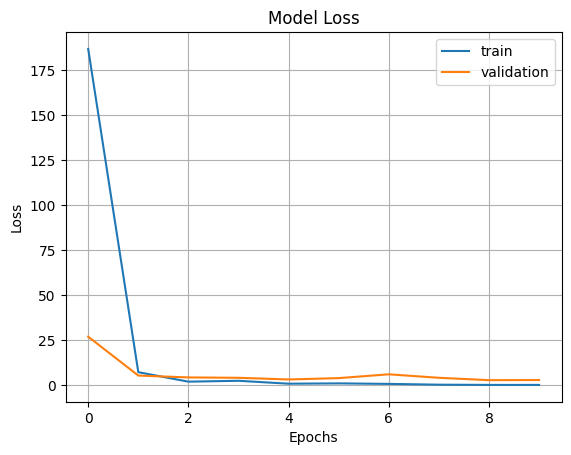

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('CNN_loss.png')